In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

import torch
from torchvision import transforms
from torch.utils.data import DataLoader

from datasets.cityscapes import Cityscapes
from utils import load_model, get_image_labels, important_classes

In [2]:
root = os.getcwd()

# Path to your cityscapes dataset folder
data_path = os.path.join(root, 'cityscapes')

# Path your model weights folder
model_path = os.path.join(root, 'models')

In [3]:
# Name of the model to test
model_name = 'resnet_test.tar'
#model_name = 'inception_frozen_0001lr.tar'

In [4]:
# Load in the model
model, optimizer, criterion, epoch, device = load_model(
                                        os.path.join(model_path, model_name))

In [5]:
#input_size = (256, 512)
original_size = (1024, 2048)
input_size = (224, 224)
num_workers = 12

In [6]:
data_transforms = transforms.Compose([transforms.Resize(input_size),
                                              transforms.ToTensor()])

resize_to_orig = transforms.Compose([transforms.ToPILImage(),
                                            transforms.Resize(original_size)])

In [7]:
# List of perturbations we'll test the model on
#perturbations = ['none', 'fog']
perturbations = ['none']

In [8]:
# Dataset and dataloader dictionaries indexed by the 
# type of perturbation it applies to images
datasets = {i: Cityscapes(data_path,
                               split='val',
                               mode='coarse',
                               target_type=['polygon'],
                               transform=data_transforms,
                               target_transform=get_image_labels,
                               perturbation=i)
                 for i in perturbations}

In [9]:
num_testing_files = datasets['none'].__len__()
print('Testing on {} test files\n'.format(num_testing_files))

Testing on 500 test files



In [10]:
# Creating PyTorch dataloaders
dataloaders = {i: DataLoader(datasets[i], batch_size=1,
                             shuffle=True, num_workers=num_workers) 
               for i in perturbations}

In [29]:
def test_model(num_imgs, model):
    # Create subplot layout and adjust vertical spacing
    fig = plt.figure(len(perturbations) * num_imgs, (12,12))
    plt.subplots_adjust(hspace = 0.3)
    
    # Tests the model on a given number of images
    imgs_so_far = 0
    for _ in range(num_imgs):
        imgs_so_far += 1
        
        # Choose a random image
        idx = np.random.randint(0, num_testing_files)
        
        # Test on each perturbation
        for perturb in perturbations:
            image, labels = datasets[perturb][idx]
            
            # Place image/labels on gpu and add batch dimension
            image = image.to(device)
            labels = labels.to(device)
            image = image.unsqueeze(0)
            
            with torch.no_grad():
                outputs = model(image)

                # Get the prediction
                preds = (torch.sigmoid(outputs) > 0.5).int()
            
            # Resizing image to its original shape
            image = resize_to_orig(image.squeeze().cpu())
            
            # Create list of labels from one-hot tensors
            label_list = []
            pred_list = []
            abels, preds = labels.squeeze(), preds.squeeze()
            for i in range(labels.size(0)):
                if labels[i] == 1:
                    label_list.append(important_classes[i])
                if preds[i] == 1:
                    pred_list.append(important_classes[i])
            
            ax = plt.subplot(num_imgs, len(perturbations), imgs_so_far)
            ax.set_title('Perturbation: {}\nLabels: {}\nPred: {}'.format(
                                        perturb, 
                                        ', '.join(label_list),
                                        ', '.join(pred_list)))
            ax.axis('off')
            ax.imshow(image)

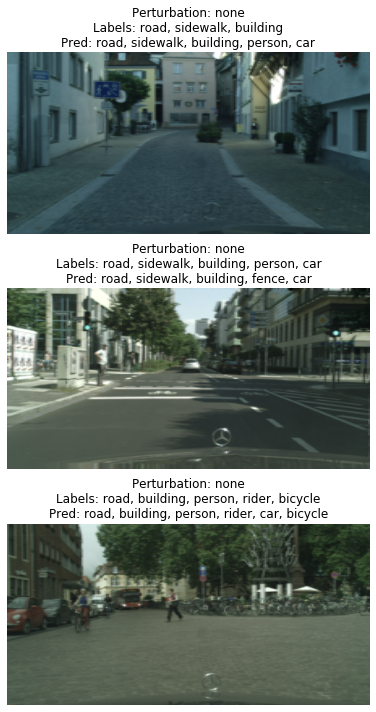

In [30]:
test_model(3, model)